### Load Packages and Data

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import pickle
import os

# The below extension properly formats a cell after it is run
%load_ext nb_black

# Setting the maximum number of rows and columns to 200
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Setting random seed
np.random.seed(42)


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [30]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [31]:
housing.shape

(2558, 65)

<IPython.core.display.Javascript object>

In [32]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

### I'm using the mean saleprice by neigbhorhood to confirm later encoding was done properly

In [33]:
# Calculate the average sale price for each neighborhood
average_sale_price = housing.groupby("Neighborhood")["SalePrice"].mean()

# Display the average sale price
print(average_sale_price)

Neighborhood
Blmngtn    196237.173913
Blueste    143590.000000
BrDale     106094.827586
BrkSide    125992.475728
ClearCr    215997.435897
CollgCr    198103.720339
Crawfor    202027.956522
Edwards    132003.993865
Gilbert    189401.965035
Greens     193531.250000
IDOTRR     109743.000000
MeadowV     96836.470588
Mitchel    163389.029126
NAmes      144960.639706
NPkVill    140743.181818
NWAmes     190329.715447
NoRidge    326114.298507
NridgHt    313662.495868
OldTown    126476.975962
SWISU      132896.048780
Sawyer     137402.215827
SawyerW    189152.017857
Somerst    228761.853147
StoneBr    305307.930233
Timber     243461.807692
Veenker    251263.043478
Name: SalePrice, dtype: float64


<IPython.core.display.Javascript object>

I'm going to encode the 'Neighborhood' column of the housing dataset using custom mapping, and encode the other categorical features using the OrdinalEncoder without specifying their categories.

In [34]:
# Getting a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# Removing the 'Neighborhood' column from cat_features since this will be dealt with in a different way
cat_features.remove('Neighborhood')


# Neighborhood mapping dictionary
Neighborhood_mapping = {
    "SWISU": 0,
    "Edwards": 1,
    "IDOTRR": 2,
    "OldTown": 3,
    "NWAmes": 4,
    "Blmngtn": 5,
    "Mitchel": 6,
    "NridgHt": 7,
    "NAmes": 8,
    "CollgCr": 9,
    "SawyerW": 10,
    "MeadowV": 11,
    "BrDale": 12,
    "Gilbert": 13,
    "Timber": 14,
    "Somerst": 15,
    "BrkSide": 16,
    "NoRidge": 17,
    "Sawyer": 18,
    "Crawfor": 19,
    "Greens": 20,
    "ClearCr": 21,
    "StoneBr": 22,
    "Veenker": 23,
    "NPkVill": 24,
    "Blueste": 25,
}

# Creating a list of neighborhoods sorted by their values in the dictionary
sorted_neighborhoods = sorted(Neighborhood_mapping, key=Neighborhood_mapping.get)

# Creating an instance of the OrdinalEncoder class with the custom categories for the 'Neighborhood' column
neighborhood_encoder = OrdinalEncoder(categories=[sorted_neighborhoods])

# Fitting and transform the 'Neighborhood' column
housing['Neighborhood'] = neighborhood_encoder.fit_transform(housing[['Neighborhood']])

# Creating an instance of the OrdinalEncoder class for the other categorical features
other_encoder = OrdinalEncoder()

# Fit and transform the other categorical features
housing[cat_features] = other_encoder.fit_transform(housing[cat_features])



<IPython.core.display.Javascript object>

The following confirms the custom mapping worked correctly

In [35]:
# Creating a copy of the housing dataframe
housing_copy = housing.copy()

# Reverting the encoded 'Neighborhood' column back to its original string values
housing_copy['Neighborhood'] = housing_copy['Neighborhood'].replace({v: k for k, v in Neighborhood_mapping.items()})

# Calculating the average sale price for each neighborhood
average_sale_price = housing_copy.groupby('Neighborhood')['SalePrice'].mean()

# Displaying the average sale price by neighborhood
print(average_sale_price)


Neighborhood
Blmngtn    196237.173913
Blueste    143590.000000
BrDale     106094.827586
BrkSide    125992.475728
ClearCr    215997.435897
CollgCr    198103.720339
Crawfor    202027.956522
Edwards    132003.993865
Gilbert    189401.965035
Greens     193531.250000
IDOTRR     109743.000000
MeadowV     96836.470588
Mitchel    163389.029126
NAmes      144960.639706
NPkVill    140743.181818
NWAmes     190329.715447
NoRidge    326114.298507
NridgHt    313662.495868
OldTown    126476.975962
SWISU      132896.048780
Sawyer     137402.215827
SawyerW    189152.017857
Somerst    228761.853147
StoneBr    305307.930233
Timber     243461.807692
Veenker    251263.043478
Name: SalePrice, dtype: float64


<IPython.core.display.Javascript object>

### Creating test/train split

In [36]:
X = housing.loc[:, housing.columns != "SalePrice"]
y = housing.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2,
)

<IPython.core.display.Javascript object>

In [37]:
print(X_train.shape)
print(X_test.shape)

(2046, 62)
(512, 62)


<IPython.core.display.Javascript object>

This code defines two functions that can be used to evaluate the performance of a scikit-learn model using cross-validation: `r2mae_scores` and `print_scores`. The `r2mae_scores` function calculates the average R^2 score and MAE score across a specified number of cross-validation folds, while the `print_scores` function prints these scores to the console. 

In [38]:
def r2mae_scores(model, X, y, cv=5):
    """
    Calculate R^2 and Mean Absolute Error (MAE) scores for the given model using cross-validation.
    
    Args:
        model: A scikit-learn model
        X: The feature matrix (numpy array or pandas DataFrame)
        y: The target variable (numpy array or pandas Series)
        cv: Number of folds for cross-validation (default: 5)

    Returns:
        avg_r2_score: The average R^2 score across the cross-validation folds
        avg_MAE_score: The average MAE score across the cross-validation folds
    """

    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    return avg_r2_score, avg_MAE_score


def print_scores(avg_r2_score, avg_MAE_score):
    """
    Print the average R^2 and MAE scores.

    Args:
        avg_r2_score: The average R^2 score
        avg_MAE_score: The average MAE score
    """
    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)

<IPython.core.display.Javascript object>

### Initial run using Random Forest Regression

In [39]:
model = ensemble.RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)

--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8985070550038822
Average MAE score: 14764.637862881904
--------------------------------------------------


<IPython.core.display.Javascript object>

## Feature Selection and Optimizing Number of Features

I'm creating four functions that will be used for feature selection and analysis: 
1.  The feature_importance function accepts a scikit-learn model (estimator), input data X, and target variable y. It fits the model on the provided data and then returns a sorted list of tuples containing the feature names and their respective importances, sorted in descending order of importance.
2. The r2_score_by_feature_count() function takes in a model, training and testing data, and returns a list of tuples with the number of features used and the mean R^2 score from 5-fold cross-validation. 
3. The plot_scores() takes in the output of r2_score_by_feature_count() and plots the feature count vs. R^2 score, with a vertical line indicating the optimal number of features.
4. The third function, plot_feature_importance(), takes in a model and the feature matrix for the training data, and plots a bar chart showing the top n_features important features for the given model based on the feature importances calculated from the training data. The function returns a sorted list of tuples containing the name of each feature and its importance score, sorted in descending order, as well as the DataFrame used for plotting the feature importance bar chart.

In [44]:
def feature_importance(model, X, y):
    """
    This function computes the feature importances of a given model, fitted on provided input data (X) and target variable (y).

    Args:
    model (sklearn estimator): The model for which feature importances will be computed.
    X (pd.DataFrame): The input features used for training the model.
    y (pd.Series, list or array-like): The target variable used for training the model.

    Returns:
    list: A sorted list of tuples containing the feature name and its importance, in descending order of importance.
    """
    model.fit(X, y)
    return sorted(
        zip(X.columns, model.feature_importances_), key=lambda t: t[1], reverse=True
    )


def r2_score_by_feature_count(model, X_train, y_train, X_test, y_test):
    """
    Calculates the R^2 score for a given model using a subset of the features in X_train and X_test.
    The R^2 score is calculated for each subset of features of increasing size.
    
    Args:
        model: A scikit-learn model
        X_train: The feature matrix for the training data (numpy array or pandas DataFrame)
        y_train: The target variable for the training data (numpy array or pandas Series)
        X_test: The feature matrix for the test data (numpy array or pandas DataFrame)
        y_test: The target variable for the test data (numpy array or pandas Series)

    Returns:
        A list of tuples containing the number of features used and the R^2 score for the given model.
    """
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features]

    scores = []
    for i in range(len(selected_columns)):
        X_train_subset = X_train[selected_columns[: i + 1]]
        X_test_subset = X_test[selected_columns[: i + 1]]

        model.fit(X_train_subset, y_train)
        score = cross_val_score(
            model, X_test_subset, y_test, cv=5, scoring="r2", n_jobs=-1
        )
        scores.append((i, np.mean(score)))

    return scores


def plot_scores(scores, vline_val):
    """
    Plots the R^2 score for a given model using a subset of the features in X_train and X_test.
    The R^2 score is calculated for each subset of features of increasing size.
    
    Args:
        scores: A list of tuples containing the number of features used and the R^2 score for the given model.
        vline_val: The optimal number of features, indicated by a vertical red line on the plot.
    """
    x_values = [t[0] for t in scores]
    y_values = [t[1] for t in scores]

    plt.plot(x_values, y_values)
    plt.axvline(x=vline_val, color="red", linestyle="--", alpha=0.4)

    plt.xlabel("# of Features")
    plt.ylabel("R^2 Performance")
    plt.title("Feature Selection")

    plt.savefig("../pic/feature_selection_optimal.png", dpi=900)
    plt.show()
    
    
def plot_feature_importance(model, X_train, n_features=35):
    """
    Plots a bar chart showing the top n_features important features for the given model based on the feature importances
    calculated from X_train.
    
    Args:
        model: A scikit-learn model
        X_train: The feature matrix for the training data (numpy array or pandas DataFrame)
        n_features: The number of features to display on the plot (default: 35)

    Returns:
        sorted_importance: A sorted list of tuples containing the name of each feature and its importance score,
                           sorted in descending order.
        df: The DataFrame used for plotting the feature importance bar chart.
    """
    sorted_importance = sorted(
        zip(X_train.columns, model.feature_importances_),
        key=lambda t: t[1],
        reverse=True,
    )

    # Get data for the plot (n_features based on your preference)
    a, b = zip(*sorted_importance[:n_features])
    df = pd.DataFrame({"feature_name": a, "importance_score": b})

    # Plot

    plt.rcParams["figure.autolayout"] = True
    plt.subplots_adjust(bottom=0.15)

    plt.figure(figsize=(20, 10))
    df.plot.bar(x="feature_name", y="importance_score", legend=None)
    plt.title("Feature Importance")

    plt.savefig("../pic/feature_importances_bar.png", dpi=900)
    plt.show()

    return sorted_importance, df



<IPython.core.display.Javascript object>

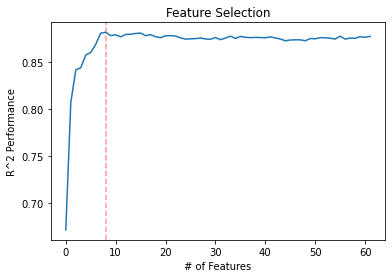

<IPython.core.display.Javascript object>

In [45]:
# Running the functions and viewing the plot of feature importance
model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)
plot_scores(scores=scores, vline_val=8)

Optimal number of features is 8

In [46]:
# Creating Random Forest Regression model and fitting the feature martix
# and target variable
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

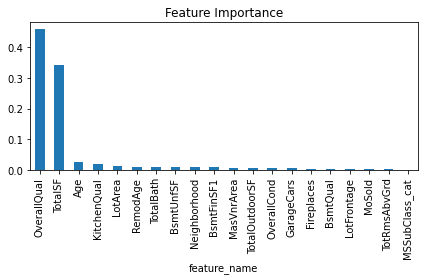

([('OverallQual', 0.4574419216463302),
  ('TotalSF', 0.341298199594038),
  ('Age', 0.025732124377614265),
  ('KitchenQual', 0.0204164225887925),
  ('LotArea', 0.012957949476761947),
  ('RemodAge', 0.012038721824442126),
  ('TotalBath', 0.011805292175810982),
  ('BsmtUnfSF', 0.010770732493802249),
  ('Neighborhood', 0.0100124558478644),
  ('BsmtFinSF1', 0.009514976373034379),
  ('MasVnrArea', 0.008958385789777394),
  ('TotalOutdoorSF', 0.007129137264409378),
  ('OverallCond', 0.006503937715420126),
  ('GarageCars', 0.005842902802993998),
  ('Fireplaces', 0.00573572105633648),
  ('BsmtQual', 0.004815873959612165),
  ('LotFrontage', 0.004427404961828037),
  ('MoSold', 0.0040712013005498125),
  ('TotRmsAbvGrd', 0.0027079870009368593),
  ('MSSubClass_cat', 0.0024025124690871904),
  ('Exterior1st', 0.001848901610576026),
  ('Street_type', 0.0017797925291402133),
  ('MSZoning', 0.001666707474699248),
  ('LandContour', 0.0016105331828132456),
  ('YrSold', 0.0015673152998911166),
  ('GarageFini

<IPython.core.display.Javascript object>

In [47]:
# Using function created earlier to plot and save feature importance
plot_feature_importance(random_forest_model, X_train, n_features=20)

## Comparing Models of Optimal Features Vs All Features

In [48]:
def compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count):
    """
    Trains and compares a machine learning model on all available features and on a subset of the most important features.
    
    Parameters:
    -----------
    model : object
        An instance of a scikit-learn machine learning model.
    X_train : array-like
        The training data features.
    y_train : array-like
        The training data labels.
    X_test : array-like
        The test data features.
    y_test : array-like
        The test data labels.
    optimal_features_count : int
        The number of top features to select for training the model.
        
    Returns:
    --------
    tuple
        A tuple of two floats representing the model's performance scores on the test data, 
        first using all available features and second using the subset of the most important features.
    """
    # Train and test the model on all available features
    model.fit(X_train, y_train)
    all_features_score = model.score(X_test, y_test)

    # Train and test the model on a subset of the most important features
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features][:optimal_features_count]

    X_train_optimal = X_train[selected_columns]
    X_test_optimal = X_test[selected_columns]

    model.fit(X_train_optimal, y_train)
    optimal_features_score = model.score(X_test_optimal, y_test)

    # Return the model's performance scores
    return all_features_score, optimal_features_score


<IPython.core.display.Javascript object>

In [49]:
# Initializing random forest regression model
model = RandomForestRegressor(random_state=0)

# Setting the number of optimal features
optimal_features_count = 8

# Training and comparing the model's performance with optimal vs all features
all_features_score, optimal_features_score = compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count)

# Printing the model's performance scores
print("R^2 score using all features: ", all_features_score)
print("R^2 score using optimal features: ", optimal_features_score)


R^2 score using all features:  0.9085632354080178
R^2 score using optimal features:  0.9022877721760434


<IPython.core.display.Javascript object>

The scores show that using all features is best and this is also what the plot shows

## Checking for Overfitting by Looking at the Train and Test Errors

In [50]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Fits a machine learning model to training data, makes predictions on both training and test sets, 
    and calculates performance metrics including mean squared error (MSE) and R^2 score.
    
    Parameters:
    -----------
    model : object
        An instance of a scikit-learn machine learning model.
    X_train : array-like
        The training data features.
    y_train : array-like
        The training data labels.
    X_test : array-like
        The test data features.
    y_test : array-like
        The test data labels.
        
    Returns:
    --------
    None
        Prints the training and test set performance metrics, including MSE and R^2 scores.
    """
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared error for the train and test sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate the R^2 for the train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Print the performance metrics for the model on both the training and test sets
    print("The training error (MSE) is: %.5f" % mse_train)
    print("The test     error (MSE) is: %.5f" % mse_test)
    print("The training R^2 is: %.5f" % r2_train)
    print("The test     R^2 is: %.5f" % r2_test)


<IPython.core.display.Javascript object>

In [51]:
random_forest_model = RandomForestRegressor(random_state=0)
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

The training error (MSE) is: 83862883.22620
The test     error (MSE) is: 541415051.26975
The training R^2 is: 0.98482
The test     R^2 is: 0.90856


<IPython.core.display.Javascript object>

The high R squared shows the model is overfitting

## Finding the optimal hyperparameters using RandomizedSearchCV and then evaluating the model's performance using the best parameters found

In [52]:
def find_best_params(X_train, y_train):
    """
    Find the best hyperparameters for a RandomForestRegressor using RandomizedSearchCV.

    Args:
    X_train: (pandas.DataFrame) Training features.
    y_train: (pandas.Series) Training target variable.

    Returns:
    best_params: (dict) Best hyperparameters found by RandomizedSearchCV.
    """

    param_grid = {
        "n_estimators": [10, 50, 100, 200],
        "max_depth": [10, 20, 30, 40, 50, 60],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [4, 8, 12],
        "max_features": ["auto", "sqrt"],
    }

    rf = RandomForestRegressor(random_state=0)
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
        random_state=0,
    )

    randomized_search.fit(X_train, y_train)

    return randomized_search.best_params_


<IPython.core.display.Javascript object>

In [53]:
# Using the find_best_params function to find the best hyperparameters
best_params = find_best_params(X_train, y_train)
print("Best parameters found by RandomizedSearchCV:")
print(best_params)

# Creating a RandomForestRegressor using the best hyperparameters and evaluating it
best_rf = RandomForestRegressor(**best_params, random_state=0)
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found by RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 60}
The training error (MSE) is: 228388361.45073
The test     error (MSE) is: 526175096.27153
The training R^2 is: 0.95867
The test     R^2 is: 0.91114


<IPython.core.display.Javascript object>

## Vizualizing Tuned Parameters

In [54]:
# Defining the grid of hyperparameters to search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [40, 50, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [4, 8, 12],
    "max_features": ["auto", "sqrt"],
}
# Initializing RandomRegressor
rf = RandomForestRegressor(random_state=0)
best_rf_GS = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_squared_error",
    random_state=0,
)
# Fitting to trainning data
best_rf_GS.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [40, 50, 60],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [4, 8, 12],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=0, scoring='neg_mean_squared_error', verbose=2)

<IPython.core.display.Javascript object>

In [55]:
# Checking best parameters
best_rf_GS.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 50}

<IPython.core.display.Javascript object>

#### max_depth and n_estimators

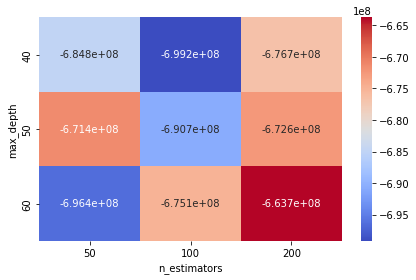

<IPython.core.display.Javascript object>

In [56]:
results = pd.DataFrame(best_rf_GS.cv_results_)
table = pd.pivot_table(
    results,
    values="mean_test_score",
    index="param_max_depth",
    columns="param_n_estimators",
)
sns.heatmap(
    table,
    annot=True,
    fmt=".4g",
    cmap="coolwarm",
    cbar_kws={"format": ticker.ScalarFormatter(useMathText=False)},
)

plt.xlabel("n_estimators")
plt.ylabel("max_depth")

plt.savefig("../pic/max_depth-n_estimators-heatmap.png", dpi=900)
plt.show()

#### min_samples_split

In [57]:
# Defining the parameter values to test
min_samples_split_values = [2, 5, 10]

# Initializing an empty list to store the mean cross-validated performance
mean_scores = []

# Looping over each value of min_samples_split and compute the mean cross-validated performance
for min_samples_split in min_samples_split_values:
    rf = RandomForestRegressor(random_state=0, min_samples_split=min_samples_split)
    randomized_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring="neg_mean_squared_error",
        random_state=0,
    )
    randomized_search.fit(X_train, y_train)
    mean_score = np.mean(randomized_search.cv_results_['mean_test_score'])
    mean_scores.append(mean_score)




Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=60, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=12, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=8, min_samples_split=10, n_estimators=50; total time=   0.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=8, min_samples_split=2, n_estimators=200; total time=   1.9s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estim

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=10, n_estimators=200; total time=   1.7s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=12, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=sq

<IPython.core.display.Javascript object>

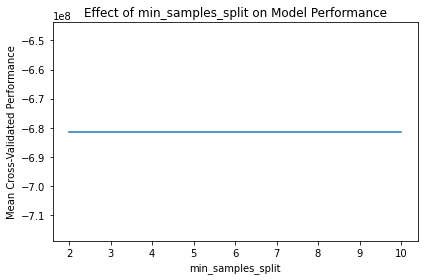

<IPython.core.display.Javascript object>

In [58]:
# Plotting the results
plt.plot(min_samples_split_values, mean_scores)
plt.xlabel("min_samples_split")
plt.ylabel("Mean Cross-Validated Performance")
plt.title("Effect of min_samples_split on Model Performance")
plt.show()

/var/folders/37/_6bzmbwj16q021_3f7fq4yv40000gp/T/ipykernel_5163/2398147226.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_samples_split_results["param_min_samples_split"] = pd.to_numeric(


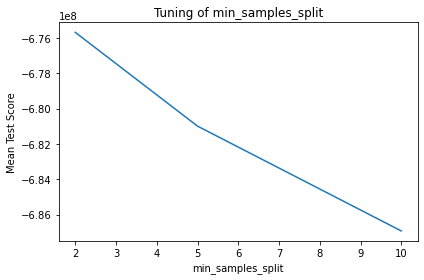

<IPython.core.display.Javascript object>

In [59]:
# Extracting the results from the GridSearchCV object
results = pd.DataFrame(best_rf_GS.cv_results_)

# Filtering the results for the min_samples_split hyperparameter
min_samples_split_results = results[["param_min_samples_split", "mean_test_score"]]

# Converting the min_samples_split hyperparameter values to numeric
min_samples_split_results["param_min_samples_split"] = pd.to_numeric(
    min_samples_split_results["param_min_samples_split"]
)

# Grouping the results by min_samples_split and calculate the mean test score
min_samples_split_results = min_samples_split_results.groupby(
    "param_min_samples_split"
).mean()

# Reseting the index
min_samples_split_results = min_samples_split_results.reset_index()

# Plotting the results as a line plot
sns.lineplot(
    x="param_min_samples_split",
    y="mean_test_score",
    data=min_samples_split_results,
)
plt.xlabel("min_samples_split")
plt.ylabel("Mean Test Score")
plt.title("Tuning of min_samples_split")

plt.savefig("../pic/min_samples_split_tuning.png", dpi=900)
plt.show()


#### min_samples_leaf

/var/folders/37/_6bzmbwj16q021_3f7fq4yv40000gp/T/ipykernel_5163/2624143712.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_samples_leaf_results["param_min_samples_leaf"] = pd.to_numeric(


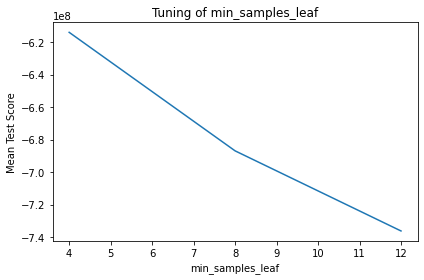

<IPython.core.display.Javascript object>

In [60]:
# Extract the results from the GridSearchCV object
results = pd.DataFrame(best_rf_GS.cv_results_)

# Filter the results for the min_samples_leaf hyperparameter
min_samples_leaf_results = results[["param_min_samples_leaf", "mean_test_score"]]

# Convert the min_samples_leaf hyperparameter values to numeric
min_samples_leaf_results["param_min_samples_leaf"] = pd.to_numeric(
    min_samples_leaf_results["param_min_samples_leaf"]
)

# Group the results by min_samples_leaf and calculate the mean test score
min_samples_leaf_results = min_samples_leaf_results.groupby(
    "param_min_samples_leaf"
).mean()

# Reset the index
min_samples_leaf_results = min_samples_leaf_results.reset_index()

# Use .loc to assign the mean test score to the DataFrame
min_samples_leaf_results.loc[:, "mean_test_score"] = min_samples_leaf_results["mean_test_score"]

# Plot the results as a line plot
sns.lineplot(
    x="param_min_samples_leaf",
    y="mean_test_score",
    data=min_samples_leaf_results,
)
plt.xlabel("min_samples_leaf")
plt.ylabel("Mean Test Score")
plt.title("Tuning of min_samples_leaf")

plt.savefig("../pic/min_samples_leaf_tuning.png", dpi=900)
plt.show()


## Stacking several models in an attempt to reduce overfitting and increase score

In [61]:

# Defining the base estimators
base_estimators = [
    ('rf', RandomForestRegressor(**best_params, random_state=0)),
    ('ridge', Ridge(random_state=0)),
    ('svr', SVR(kernel='linear'))
]

# Creating the stacking regressor
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=Ridge(random_state=0))

# Evaluating the stacking regressor
evaluate_model(stacking_regressor, X_train, y_train, X_test, y_test)


The training error (MSE) is: 285685746.61138
The test     error (MSE) is: 423609991.18574
The training R^2 is: 0.94830
The test     R^2 is: 0.92846


<IPython.core.display.Javascript object>

StackingRegressor brings test score up to .927 and training score down to .947 which improves the overfitting problem.  However we decided to go with random forest since it will work better with SHAP

Saving as a pickle to be used for Shap in another notebook

In [62]:
# Defining the file paths for saving the pickled objects
best_rf_path = os.path.join("..", "data", "best_rf.pkl")
X_train_path = os.path.join("..", "data", "X_train.pkl")

# Saving the best_rf model
with open(best_rf_path, "wb") as f:
    pickle.dump(best_rf, f)

# Saving the X_train DataFrame
X_train.to_pickle(X_train_path)


<IPython.core.display.Javascript object>